# Currency Classifier 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/piyush/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = "../data/"

In [6]:
os.listdir(PATH)

['valid', 'models', 'tmp', 'train']

In [7]:
os.listdir(f'{PATH}valid')

['usd', 'inr']

In [8]:
files = os.listdir(f'{PATH}valid/inr')[:5]
files

['68. 1468159882_vmvd2c_indianrupee.jpg',
 '33. 28410470-indian-rupee-notes-and-coins.jpg',
 '184. variations-of-indian-rupee-picture-id89581384?s=612x612.jpg',
 '149. maxresdefault.jpg',
 '11. ntd_indian_currency_changing_colours4-640x359.jpg']

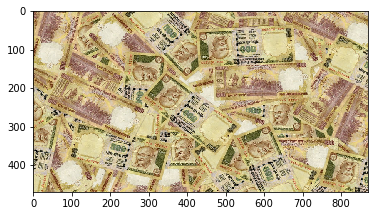

In [9]:
img = plt.imread(f'{PATH}valid/inr/{files[0]}')
plt.imshow(img);

In [10]:
img.shape

(470, 870, 3)

In [11]:
img[:4,:4]

array([[[114,  79,  47],
        [153, 116,  89],
        [150, 112,  89],
        [165, 127, 108]],

       [[143, 104,  73],
        [167, 127, 101],
        [171, 130, 108],
        [152, 109,  92]],

       [[122,  80,  55],
        [128,  86,  62],
        [161, 116,  97],
        [139,  93,  77]],

       [[164, 117,  97],
        [159, 112,  92],
        [168, 121, 103],
        [131,  82,  67]]], dtype=uint8)

In [12]:
sz=224
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [13]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [14]:
ims = np.stack([get_augs() for i in range(6)])

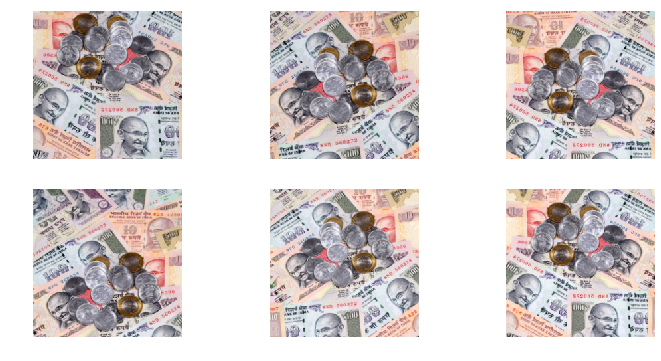

In [15]:
plots(ims, rows=2)

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=20)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5) 

epoch      trn_loss   val_loss   accuracy        
    0      0.697986   0.204546   0.890625  
    1      0.47107    0.165516   0.9375                     
    2      0.362757   0.175218   0.9375          
    3      0.279036   0.163179   0.953125        
    4      0.235796   0.156247   0.96875         



[0.1562471508514136, 0.9687499925494194]

In [17]:
data.classes

['inr', 'usd']

In [18]:
log_preds = learn.predict()
log_preds.shape

(64, 2)

In [19]:
log_preds[:10]

array([[-0.00443, -5.4222 ],
       [-0.00968, -4.64258],
       [-0.00834, -4.79102],
       [-1.48115, -0.25796],
       [-0.0123 , -4.4039 ],
       [-0.00537, -5.22962],
       [-0.00039, -7.84664],
       [-0.11947, -2.18385],
       [-0.00386, -5.56026],
       [-0.00362, -5.62214]], dtype=float32)

In [20]:
preds = np.argmax(log_preds, axis=1)  
probs = np.exp(log_preds[:,1])        

In [21]:
def rand_by_mask(mask):
    mask_idxs = np.where(mask)[0]
    cnt = min(4, len(mask_idxs))
    return np.random.choice(mask_idxs, cnt, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [22]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [23]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


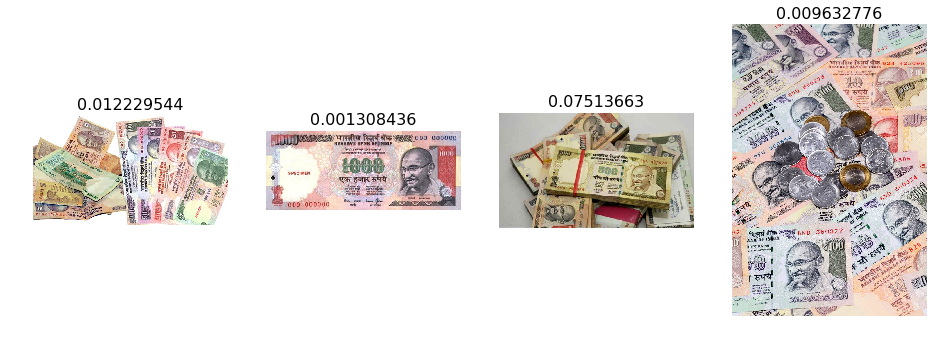

In [24]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


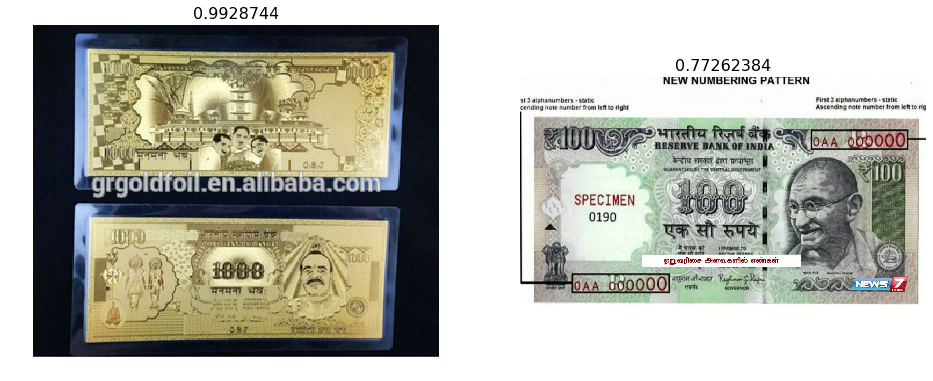

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [26]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct INR


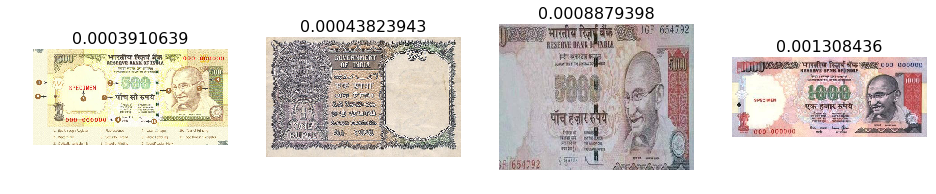

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct INR")

Most correct USD


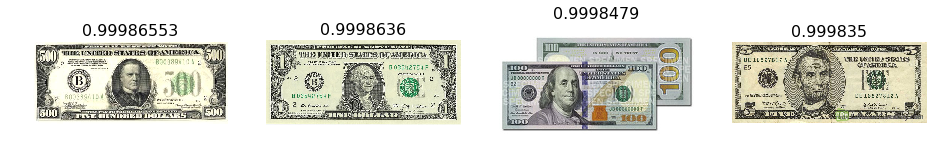

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct USD")

Most incorrect INR


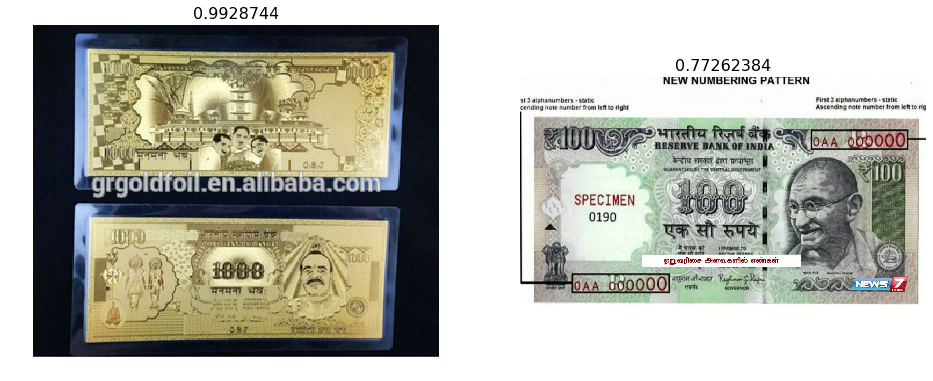

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect INR")

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect USD")

Most incorrect USD
Not Found.


Most uncertain predictions


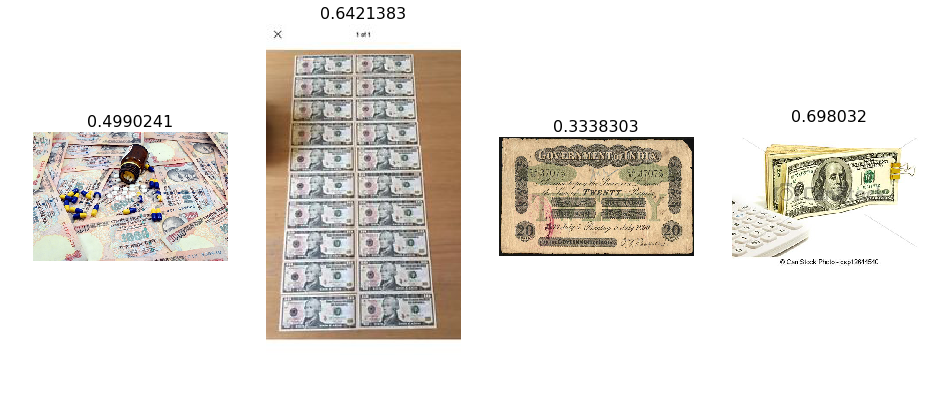

In [31]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [32]:
learn.precompute=False

In [33]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.259858   0.180661   0.921875  
    1      0.238615   0.202297   0.921875                  
    2      0.224487   0.165754   0.921875                  



[0.16575446329079568, 0.921875]

In [34]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [35]:
accuracy_np(probs, y)

0.96875

In [36]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[30  2]
 [ 0 32]]


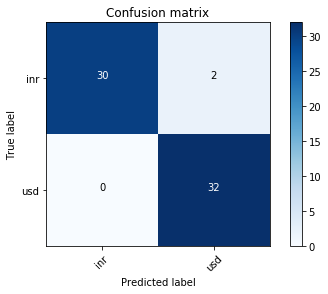

In [38]:
plot_confusion_matrix(cm, data.classes)

Most incorrect INR


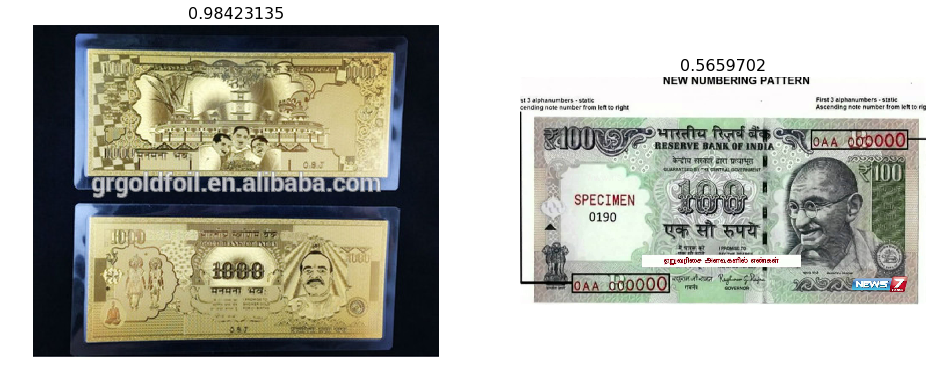

In [39]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect INR")

In [40]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect USD")

Most incorrect USD
Not Found.
